In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from theano.tensor import eq
from IPython.display import Image
from matplotlib import gridspec

%matplotlib inline
plt.style.use('seaborn-white')

color = 'cyan'

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn,theano

pandas 0.23.4
numpy 1.15.4
pymc3 3.6
matplotlib 3.0.2
seaborn 0.9.0
theano 1.0.3


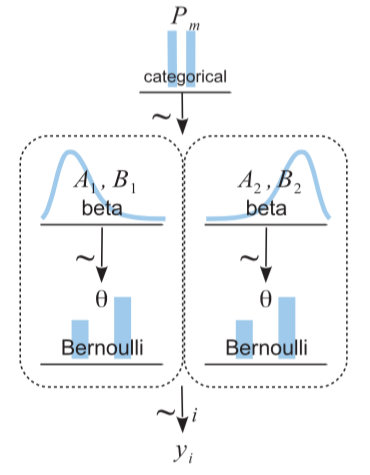

In [3]:
#10.3.2 Hierarchial MCMC model probibility like this
Image('images/fig10_2.png', width=300)


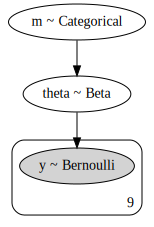

In [4]:
#one theta value coin flip nine times with 6 heads

with pm.Model() as hierarchical_model:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    kappa = 12
    
    omega = pm.math.switch(eq(m, 0), .25, .75)
    
    theta = pm.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1)
    
    y = pm.Bernoulli('y', theta, observed=[1,1,1,1,1,1,0,0,0])

pm.model_to_graphviz(hierarchical_model)

In [5]:
with hierarchical_model:
    trace = pm.sample(5000, cores=4, nuts_kwargs={'target_accept': 0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:11<00:00, 1959.05draws/s]
The number of effective samples is smaller than 25% for some parameters.


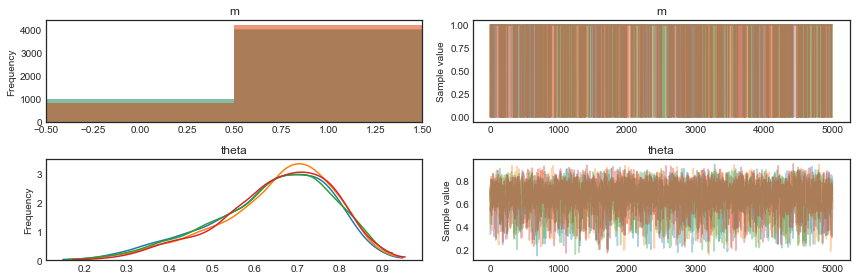

In [6]:
pm.traceplot(trace);

In [7]:
trace_df = (pm.trace_to_dataframe(trace)
            .set_index('m'))
trace_df.head()

,theta
m,
0,0.533686
1,0.533686
0,0.571673
0,0.336816
0,0.376062


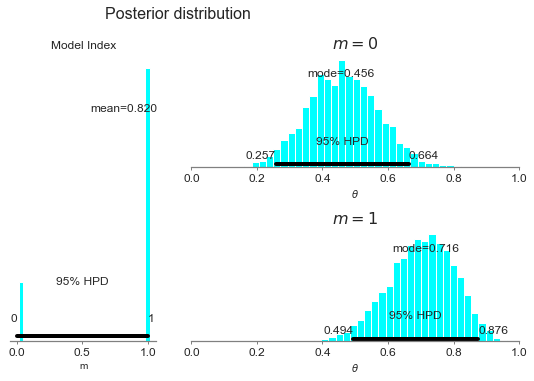

In [8]:
#10.4 models start at 0 not 1, so parameter m is shifted with -1

fig = plt.figure(figsize=(10,5))

font_d = {'size':16}

# Define gridspec
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0:,1])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,2:])

# Distplot m
pm.plot_posterior(np.asarray(trace_df.index), ax=ax1, color=color)
ax1.set_xlabel('m')
ax1.set_title('Model Index')

# Distplot theta for m=0 and m=1 
for model, ax in zip((0,1), (ax2, ax3)):
    pm.plot_posterior(trace_df.loc[model].values.ravel(), point_estimate='mode', ax=ax, color=color)
    ax.set_title(r'$m = {}$'.format(model), fontdict=font_d)    
    ax.set(xlim=(0,1), xlabel=r'$\theta$')

fig.suptitle('Posterior distribution', size=16, y=1.05)
    
fig.tight_layout(w_pad=2);

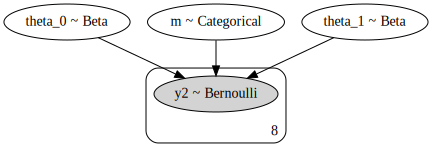

In [9]:
#Model 2 with 2 theta's no pseudo priors, coin flip 9 wit hsix heads

with pm.Model() as hierarchical_model2:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    omega_0 = .25
    kappa_0 = 12
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0-2)+1, (1-omega_0)*(kappa_0-2)+1)
    
    omega_1 = .75
    kappa_1 = 12
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1-2)+1, (1-omega_1)*(kappa_1-2)+1)
    
    theta = pm.math.switch(eq(m, 0), theta_0, theta_1)
    
    y2 = pm.Bernoulli('y2', theta, observed=[1,1,1,1,1,0,0,0])

pm.model_to_graphviz(hierarchical_model2)

In [10]:
with hierarchical_model2:
    trace2 = pm.sample(5000, cores=4, nuts_kwargs={'target_accept': 0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_1, theta_0]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:14<00:00, 1527.01draws/s]


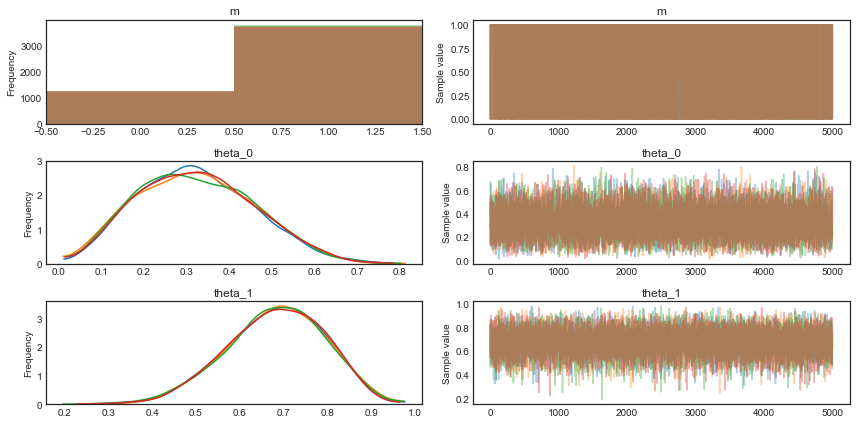

In [11]:
pm.traceplot(trace2);

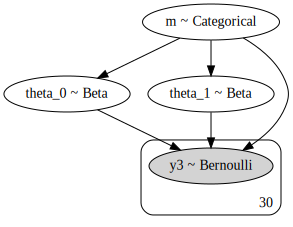

In [12]:
#Model 3, two theta variables with pseudo priors

with pm.Model() as hierarchical_model3:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 20
    kappa_0 = pm.math.switch(eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = .10
    omega_0_pseudo_p = .10
    omega_0 = pm.math.switch(eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0-2)+1, (1-omega_0)*(kappa_0-2)+1)
    
    # Theta1    
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 20 
    kappa_1 = pm.math.switch(eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = .90
    omega_1_pseudo_p = .90
    omega_1 = pm.math.switch(eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1-2)+1, (1-omega_1)*(kappa_1-2)+1)
    
    theta = pm.math.switch(eq(m, 0), theta_0, theta_1)
    
    y3 = pm.Bernoulli('y3', theta, observed=np.r_[17*[1], 13*[0]])

pm.model_to_graphviz(hierarchical_model3)

In [13]:
with hierarchical_model3:
    trace3 = pm.sample(5000, cores=4, nuts_kwargs={'target_accept': 0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_1, theta_0]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:13<00:00, 1586.35draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [14]:
trace3_df = (pm.trace_to_dataframe(trace3)
             .set_index('m')[['theta_0', 'theta_1']])
trace3_df.head()

,theta_0,theta_1
m,,
1,0.046972,0.729654
1,0.104510,0.739727
1,0.104247,0.735500
1,0.189698,0.757988
1,0.159105,0.868606


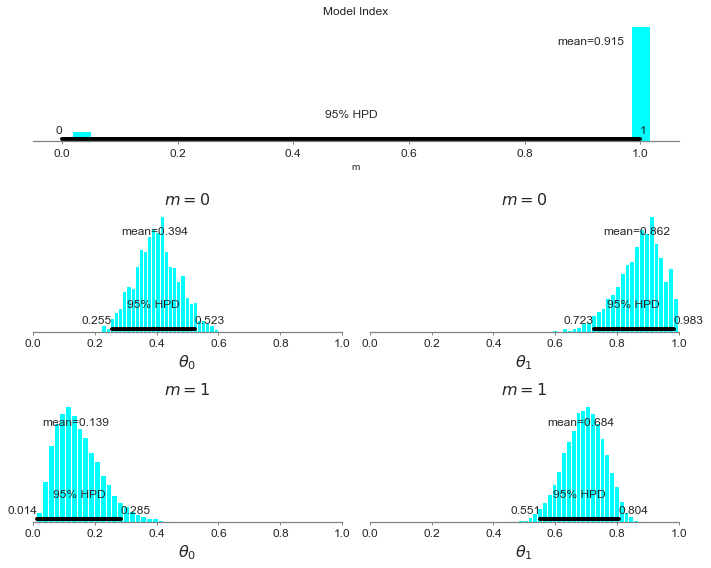

In [15]:
#Fig 10.5 lower

fig = plt.figure(figsize=(10,8))

# Define gridspec
gs = gridspec.GridSpec(3,2)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

pm.plot_posterior(np.asarray(trace3_df.index), ax=ax1, color=color)
ax1.set_xlabel('m')
ax1.set_title('Model Index')

for model, theta, ax in zip((0,0,1,1), (0,1,0,1), (ax2, ax3, ax4, ax5)):
    pm.plot_posterior(trace3_df.loc[model, 'theta_{}'.format(theta)].values, ax=ax, color=color)
    ax.set_title(r'$m = {}$'.format(model), fontdict=font_d)
    ax.set_xlim(0,1)
    ax.set_xlabel(r'$\theta_{}$'.format(theta), fontdict=font_d)
    
fig.tight_layout();

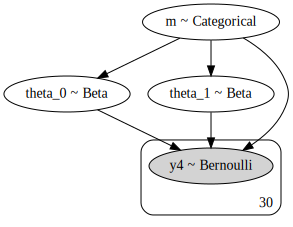

In [16]:
#Model 4, two theat vars with psedo priors mimic posteriors Coin flip 30 , 17 heads

with pm.Model() as hierarchical_model4:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 50
    kappa_0 = pm.math.switch(eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = .10
    omega_0_pseudo_p = .40
    omega_0 = pm.math.switch(eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0-2)+1, (1-omega_0)*(kappa_0-2)+1)
    
    # Theta1    
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 50 
    kappa_1 = pm.math.switch(eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = .90
    omega_1_pseudo_p = .70
    omega_1 = pm.math.switch(eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1-2)+1, (1-omega_1)*(kappa_1-2)+1)
    
    theta = pm.math.switch(eq(m, 0), theta_0, theta_1)
    
    y4 = pm.Bernoulli('y4', theta, observed=np.r_[17*[1], 13*[0]])

pm.model_to_graphviz(hierarchical_model4)

In [17]:
with hierarchical_model4:
    trace4 = pm.sample(5000, cores=4, nuts_kwargs={'target_accept': 0.95})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_1, theta_0]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:13<00:00, 1582.50draws/s]


In [18]:
trace4_df = (pm.trace_to_dataframe(trace4)
            .set_index('m')[['theta_0', 'theta_1']])
trace4_df.head()

,theta_0,theta_1
m,,
1,0.414705,0.681975
1,0.336848,0.707505
1,0.419476,0.695246
1,0.419476,0.695246
1,0.347467,0.700889


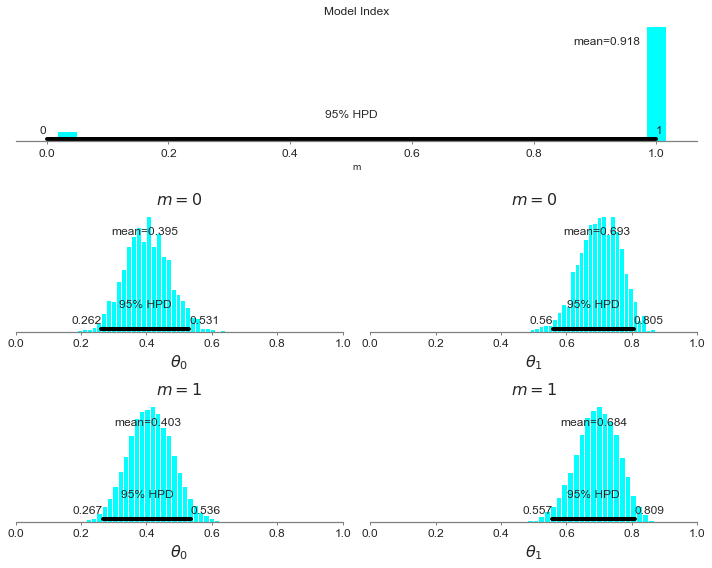

In [19]:
#Fig 10.6 lower

fig = plt.figure(figsize=(10,8))

# Define gridspec
gs = gridspec.GridSpec(3,2)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

pm.plot_posterior(np.asarray(trace4_df.index), ax=ax1, color=color)
ax1.set_xlabel('m')
ax1.set_title('Model Index')

for model, theta, ax in zip((0,0,1,1), (0,1,0,1), (ax2, ax3, ax4, ax5)):
    pm.plot_posterior(trace4_df.loc[model, 'theta_{}'.format(theta)].values, ax=ax, color=color)
    ax.set_title(r'$m = {}$'.format(model), fontdict=font_d)
    ax.set_xlim(0,1)
    ax.set_xlabel(r'$\theta_{}$'.format(theta), fontdict=font_d)
    
fig.tight_layout();